## Supervised Machine Learning Techniques Assignment II--Yidan Li yl4357

## Table of Content
* [1.Data Preparation](#1)
 * [Drop highly missing/ single value/ not meaningful variables](#1.1)
 * [Binning and encoding missing and special values](#1.2)
 * [Encoding categorical and string variables](#1.3)
* [2.Define functions](#2)
* [3.GLM with h2o](#3)
 * [GLM on small sample dataset (no resampling)](#3.1)
 * [GLM on entire dataset (no resampling)](#3.2)
 * [GLM on entire dataset (with regularization)](#3.3)
 * [GLM on entire dataset (with regularization, random oversampling)](#3.4)
 * [GLM on entire dataset (with regularization, random undersampling)](#3.5)
* [4.AutoML](#4)

In [51]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import plotly
import plotly.express as px
import seaborn as sns

In [52]:
df=pd.read_csv('/Users/liyidan/Desktop/Anomaly Detection/8. Supervised Learning/XYZloan_default_selected_vars.csv')
print(df.head(3))
print(df['loan_default'].value_counts())

   Unnamed: 0  Unnamed: 0.1  id  loan_default  AP001  AP002  AP003  AP004  \
0           0             1   1             1     31      2      1     12   
1           1             2   2             0     27      1      1     12   
2           2             3   3             0     33      1      4     12   

            AP005 AP006  AP007  AP008  AP009  TD001  TD002  TD005  TD006  \
0  2017/7/6 10:21   ios      3      3      1      1      1      4      1   
1  2017/4/6 12:51    h5      5      4      0      2      0      3      1   
2  2017/7/1 14:11    h5      4      2      0      2      1      4      1   

   TD009  TD010  TD013  TD014  TD015  TD022  TD023  TD024  TD025  TD026  \
0      5      1     14      2      2   10.0    9.0    6.0    0.0    0.0   
1      3      1      3      2      0   15.0    6.0    0.0    0.0    0.0   
2      5      1      9      1      2   15.0    9.0    2.0    0.0    0.0   

   TD027  TD028  TD029  TD044  TD048  TD051  TD054  TD055  TD061  TD062  \
0    0.0  

### 1. Data Preparation <a class="anchor" id="1"></a>

Explore the columns with missing value and their data types

In [53]:
null_cols=df.columns[df.isnull().any()]
print(null_cols)  #columns with NA values
print(df.select_dtypes(include=['float64','int64']).columns)  #numeric columns
print(df.select_dtypes(include=['object']).columns)  #categorical columns
#all columns with NA values are numeric

Index(['TD022', 'TD023', 'TD024', 'TD025', 'TD026', 'TD027', 'TD028', 'TD029',
       'TD044', 'TD048', 'TD051', 'TD054', 'TD055', 'TD061', 'TD062', 'PA022',
       'PA023', 'PA028', 'PA029', 'PA030', 'PA031', 'CD008', 'CD018', 'CD071',
       'CD072', 'CD088', 'CD100', 'CD101', 'CD106', 'CD107', 'CD108', 'CD113',
       'CD114', 'CD115', 'CD117', 'CD118', 'CD120', 'CD121', 'CD123', 'CD130',
       'CD131', 'CD132', 'CD133', 'CD135', 'CD136', 'CD137', 'CD152', 'CD153',
       'CD160', 'CD162', 'CD164', 'CD166', 'CD167', 'CD169', 'CD170', 'CD172',
       'CD173', 'MB005'],
      dtype='object')
Index(['Unnamed: 0', 'Unnamed: 0.1', 'id', 'loan_default', 'AP001', 'AP002',
       'AP003', 'AP004', 'AP007', 'AP008', 'AP009', 'TD001', 'TD002', 'TD005',
       'TD006', 'TD009', 'TD010', 'TD013', 'TD014', 'TD015', 'TD022', 'TD023',
       'TD024', 'TD025', 'TD026', 'TD027', 'TD028', 'TD029', 'TD044', 'TD048',
       'TD051', 'TD054', 'TD055', 'TD061', 'TD062', 'CR004', 'CR005', 'CR009',
      

#### Drop highly missing/ single value/ not meaningful variables <a class="anchor" id="1.1"></a>

In [54]:
#drop variables that are not meaningful for prediction
df=df.drop(['id','Unnamed: 0', 'Unnamed: 0.1'], axis=1)

In [55]:
#drop variables with only 1 unique value (including all missing variables)
for col in df.columns:
    if df[col].nunique() == 1:
        df.drop(col,inplace=True,axis=1)

In [56]:
#further examine columns with missing values
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent =100*df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Missing Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Missing Values', ascending=False).round(1)

        print ("The selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
missing_values_table(df)

The selected dataframe has 73 columns.
There are 46 columns that have missing values.


,Missing Values,% of Missing Values
TD022,19598,24.5
TD023,7663,9.6
TD024,3694,4.6
MB005,2793,3.5
PA023,381,0.5
CD153,381,0.5
CD130,381,0.5
CD131,381,0.5
CD132,381,0.5
CD133,381,0.5


In [57]:
pd.options.display.max_columns = 100
df.describe()

,loan_default,AP001,AP002,AP003,AP004,AP007,AP008,AP009,TD001,TD002,TD005,TD006,TD009,TD010,TD013,TD014,TD015,TD022,TD023,TD024,CR004,CR005,CR009,CR015,CR017,CR018,CR019,PA022,PA023,PA028,PA029,PA030,PA031,CD008,CD018,CD071,CD072,CD088,CD100,CD101,CD106,CD107,CD108,CD113,CD114,CD115,CD117,CD118,CD120,CD121,CD123,CD130,CD131,CD132,CD133,CD135,CD136,CD137,CD152,CD153,CD160,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.00000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.00000,80000.000000,80000.000000,80000.000000,80000.000000,60402.000000,72337.000000,76306.000000,80000.000000,80000.000000,8.000000e+04,80000.000000,80000.000000,80000.000000,80000.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.00000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,7.961900e+04,7.961900e+04,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.00000,79619.000000,79619.000000,77207.000000
mean,0.193600,31.706913,1.321813,2.014925,11.235413,3.30130,3.117200,0.727925,1.986962,0.706213,3.593037,1.345700,5.40600,2.020812,6.804737,2.603662,0.718775,17.120294,7.293156,5.541687,2.503450,1.595638,3.518711e+04,4.924750,5.234962,4.361112,6.199038,19.298811,14.828822,-36.738300,-42.407356,-74.438095,-48.404044,13470.599066,426.021427,34.502167,30.631106,40.050993,4.812457,0.586883,9.460857,3.010374,2.331253,-0.594243,1.176352,68.37697,48.368995,115.663070,83.749532,155.066228,113.074379,88.081815,81.524159,99.278916,108.111493,130.041146,120.280850,143.578153,1.360805e+04,1.366809e+04,6.911956,14.271694,11.773358,909.089313,810.786219,1732.693314,1539.33443,2513.226491,2229.606137,5.976272
std,0.395121,7.075070,0.467174,1.196806,2.212313,1.33655,1.306335,0.445031,1.807445,0.918347,2.799570,1.413362,4.02311,1.973988,5.128183,2.505840,0.882962,7.024737,7.395779,6.157043,1.117991,1.083602,6.359684e+04,1.094305,2.398870,2.498607,3.359354,39.705478,37.009374,100.731779,97.006168,74.146246,96.313406,13058.772406,373.327926,66.483870,61.899563,78.969397,43.655893,29.029802,61.423633,37.172491,35.030955,21.642171,23.311023,60.57446,46.932544,91.713711,69.112448,116.368152,86.765922,90.320004,88.529928,96.068148,96.793174,123.525977,120.935487,130.487618,1.905389e+04,1.935326e+04,28.007499,38.235012,33.270641,1379.553332,1245.044602,2441.503517,2172.71384,3404.975112,3005.615048,3.641814
min,0.000000,20.000000,1.000000,1.000000,3.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,1.000000,1.000000,0.000000e+00,2.000000,1.000000,0.000000,1.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.00000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-9.900000e+01,-9.900000e+01,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.00000,-99.000000,-99.000000,0.000000
25%,0.000000,27.000000,1.000000,1.000000,12.000000,2.00000,2.000000,0.000000,1.000000,0.000000,2.000000,0.000000,3.00000,1.000000,3.000000,1.000000,0.000000,10.000000,3.000000,2.000000,2.000000,1.000000,4.700000e+03,5.000000,3.000000,2.000000,3.000000,-1.000000,-1.000000,-98.000000,-98.000000,-98.000000,-98.000000,4769.500000,163.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.00000,28.000000,65.000000,48.000000,88.000000,65.000000,31.000000,26.000000,40.000000,48.000000

According to the variable description, variable PA022-CD173 should all be positive, but they all have negative values inside as shown in the above statistics, like -99, -1, which should be put in a new category, these variables will be included in the same category with NA values.

#### Binning and encoding missing and special values <a class="anchor" id="1.2"></a>

In [58]:
var_with_na=df.columns[df.isnull().any()]
var_with_na

Index(['TD022', 'TD023', 'TD024', 'PA022', 'PA023', 'PA028', 'PA029', 'PA030',
       'PA031', 'CD008', 'CD018', 'CD071', 'CD072', 'CD088', 'CD100', 'CD101',
       'CD106', 'CD107', 'CD108', 'CD113', 'CD114', 'CD115', 'CD117', 'CD118',
       'CD120', 'CD121', 'CD123', 'CD130', 'CD131', 'CD132', 'CD133', 'CD135',
       'CD136', 'CD137', 'CD152', 'CD153', 'CD160', 'CD162', 'CD164', 'CD166',
       'CD167', 'CD169', 'CD170', 'CD172', 'CD173', 'MB005'],
      dtype='object')

In [59]:
def binning(var):
    df[var].loc[df[var]==-99]=float('NaN')
    df[var].loc[df[var]==-98]=float('NaN')
    df[var].loc[df[var]==-1]=float('NaN')#convert all negative values to NA values
    df[var + '_bin'] = pd.qcut(df[var],10,duplicates='drop').values.add_categories("NoData")
    df[var + '_bin'] = df[var + '_bin'].fillna("NoData").astype('category') #assign NA values the category 'NoData'

import warnings
warnings.filterwarnings("ignore")   
    
for i in var_with_na:
    binning(i)

In [60]:
df.head(3)

,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,AP009,TD001,TD002,TD005,TD006,TD009,TD010,TD013,TD014,TD015,TD022,TD023,TD024,CR004,CR005,CR009,CR015,CR017,CR018,CR019,PA022,PA023,PA028,PA029,PA030,PA031,CD008,CD018,CD071,CD072,CD088,CD100,CD101,CD106,CD107,CD108,CD113,CD114,CD115,CD117,CD118,...,CD172,CD173,MB005,MB007,TD022_bin,TD023_bin,TD024_bin,PA022_bin,PA023_bin,PA028_bin,PA029_bin,PA030_bin,PA031_bin,CD008_bin,CD018_bin,CD071_bin,CD072_bin,CD088_bin,CD100_bin,CD101_bin,CD106_bin,CD107_bin,CD108_bin,CD113_bin,CD114_bin,CD115_bin,CD117_bin,CD118_bin,CD120_bin,CD121_bin,CD123_bin,CD130_bin,CD131_bin,CD132_bin,CD133_bin,CD135_bin,CD136_bin,CD137_bin,CD152_bin,CD153_bin,CD160_bin,CD162_bin,CD164_bin,CD166_bin,CD167_bin,CD169_bin,CD170_bin,CD172_bin,CD173_bin,MB005_bin
0,1,31,2,1,12,2017/7/6 10:21,ios,3,3,1,1,1,4,1,5,1,14,2,2,10.0,9.0,6.0,2,1,35807,4,4,3,2,NaN,NaN,NaN,NaN,NaN,NaN,13840.0,172.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,57.0,48.0,95.0,...,2249.0,2249.0,7.0,IPHONE7,"(9.999, 15.0]","(6.0, 9.0]","(4.0, 6.0]",NoData,NoData,NoData,NoData,NoData,NoData,"(13171.0, 16592.0]","(152.0, 214.0]","(-0.001, 3.0]","(-0.001, 3.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(55.0, 65.0]","(47.0, 55.0]","(92.0, 107.0]","(68.0, 79.0]","(123.0, 144.0]","(91.0, 106.0]","(28.0, 43.0]","(52.0, 67.0]","(52.0, 68.0]","(45.0, 61.0]","(44.0, 66.0]","(77.0, 100.0]","(77.0, 99.0]","(9081.0, 11685.0]","(12444.0, 15706.0]","(7.0, 9.0]","(10.0, 13.0]","(11.0, 14.0]","(-0.001, 64.0]","(-0.001, 8.0]","(1098.0, 1498.0]","(1306.0, 1793.0]","(2216.0, 2936.7]","(1930.0, 2606.0]","(6.0, 7.0]"
1,0,27,1,1,12,2017/4/6 12:51,h5,5,4,0,2,0,3,1,3,1,3,2,0,15.0,6.0,0.0,3,1,7254,6,7,6,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,WEB,"(9.999, 15.0]","(3.0, 6.0]","(-0.001, 2.0]",NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData
2,0,33,1,4,12,2017/7/1 14:11,h5,4,2,0,2,1,4,1,5,1,9,1,2,15.0,9.0,2.0,2,2,30377,2,2,2,3,NaN,NaN,NaN,NaN,NaN,NaN,2454.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,13.0,20.0,...,143.0,110.0,8.0,WEB,"(9.999, 15.0]","(6.0, 9.0]","(-0.001, 2.0]",NoData,NoData,NoData,NoData,NoData,NoData,"(-0.001, 2536.0]","(-0.001, 89.0]","(-0.001, 3.0]","(-0.001, 3.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 26.0]","(-0.001, 19.0]","(-0.001, 45.0]","(-0.001, 33.0]","(-0.001, 62.0]","(-0.001, 45.0]","(-0.001, 12.0]","(-0.001, 10.0]","(-0.001, 22.0]","(-0.001, 27.0]","(-0.001, 21.0]","(-0.001, 18.0]","(-0.001, 32.0]","(3604.0, 5189.0]","(-0.001, 2558.1]","(-0.001, 1.0]","(2.0, 5.0]","(1.0, 4.0]","(-0.001, 64.0]","(-0.001, 8.0]","(-0.001, 68.0]","(-0.001, 7.0]","(-0.001, 172.0]","(105.0, 366.0]","(7.0, 9.0]"


#### Encode the binned variables using LabelEncoder

In [61]:
from sklearn.preprocessing import LabelEncoder
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
filter_col = [col for col in df if col.endswith('bin')]
filter_col
for var in filter_col:
    df[var]=df[var].astype(str)
    df[var]=labelencoder.fit_transform(df[var])

In [62]:
df.head(3)

,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,AP009,TD001,TD002,TD005,TD006,TD009,TD010,TD013,TD014,TD015,TD022,TD023,TD024,CR004,CR005,CR009,CR015,CR017,CR018,CR019,PA022,PA023,PA028,PA029,PA030,PA031,CD008,CD018,CD071,CD072,CD088,CD100,CD101,CD106,CD107,CD108,CD113,CD114,CD115,CD117,CD118,...,CD172,CD173,MB005,MB007,TD022_bin,TD023_bin,TD024_bin,PA022_bin,PA023_bin,PA028_bin,PA029_bin,PA030_bin,PA031_bin,CD008_bin,CD018_bin,CD071_bin,CD072_bin,CD088_bin,CD100_bin,CD101_bin,CD106_bin,CD107_bin,CD108_bin,CD113_bin,CD114_bin,CD115_bin,CD117_bin,CD118_bin,CD120_bin,CD121_bin,CD123_bin,CD130_bin,CD131_bin,CD132_bin,CD133_bin,CD135_bin,CD136_bin,CD137_bin,CD152_bin,CD153_bin,CD160_bin,CD162_bin,CD164_bin,CD166_bin,CD167_bin,CD169_bin,CD170_bin,CD172_bin,CD173_bin,MB005_bin
0,1,31,2,1,12,2017/7/6 10:21,ios,3,3,1,1,1,4,1,5,1,14,2,2,10.0,9.0,6.0,2,1,35807,4,4,3,2,NaN,NaN,NaN,NaN,NaN,NaN,13840.0,172.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,57.0,48.0,95.0,...,2249.0,2249.0,7.0,IPHONE7,3,4,4,10,10,10,10,10,10,2,1,0,0,0,0,0,0,0,0,0,0,6,6,9,7,2,9,5,7,7,6,7,9,8,9,1,8,1,2,0,0,1,1,4,4,6
1,0,27,1,1,12,2017/4/6 12:51,h5,5,4,0,2,0,3,1,3,1,3,2,0,15.0,6.0,0.0,3,1,7254,6,7,6,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,WEB,3,3,0,10,10,10,10,10,10,10,10,8,8,9,7,5,8,6,6,6,7,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,9,9,10,10,10,10,9
2,0,33,1,4,12,2017/7/1 14:11,h5,4,2,0,2,1,4,1,5,1,9,1,2,15.0,9.0,2.0,2,2,30377,2,2,2,3,NaN,NaN,NaN,NaN,NaN,NaN,2454.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,13.0,20.0,...,143.0,110.0,8.0,WEB,3,4,0,10,10,10,10,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,4,1,0,0,0,0,0,2,7


#### Encoding categorical and string variables (AP002, AP005, AP006, MB007)  <a class="anchor" id="1.3"></a>

In [63]:
#extract year, month, day, hour, weekday from AP005
from datetime import datetime
df['AP005'] = pd.to_datetime(df['AP005'])
df['year'] = pd.DatetimeIndex(df['AP005']).year
df['month'] = pd.DatetimeIndex(df['AP005']).month
df['day'] = pd.DatetimeIndex(df['AP005']).day
df['hour'] = pd.DatetimeIndex(df['AP005']).hour
df['weekday'] = pd.DatetimeIndex(df['AP005']).dayofweek
#encoding
df['year'] =labelencoder.fit_transform(df['year'])
df['month'] = labelencoder.fit_transform(df['month'])
df['day'] = labelencoder.fit_transform(df['day'])
df['hour'] =labelencoder.fit_transform(df['hour'])
df['weekday'] = labelencoder.fit_transform(df['weekday'])

In [64]:
#age data
df['AP001'].isnull().sum()
binning('AP001')
df['AP001_bin']=labelencoder.fit_transform(df['AP001_bin'])
#gender data
df['AP002']=labelencoder.fit_transform(df['AP002'])

In [65]:
df.head(3)

,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,AP009,TD001,TD002,TD005,TD006,TD009,TD010,TD013,TD014,TD015,TD022,TD023,TD024,CR004,CR005,CR009,CR015,CR017,CR018,CR019,PA022,PA023,PA028,PA029,PA030,PA031,CD008,CD018,CD071,CD072,CD088,CD100,CD101,CD106,CD107,CD108,CD113,CD114,CD115,CD117,CD118,...,TD024_bin,PA022_bin,PA023_bin,PA028_bin,PA029_bin,PA030_bin,PA031_bin,CD008_bin,CD018_bin,CD071_bin,CD072_bin,CD088_bin,CD100_bin,CD101_bin,CD106_bin,CD107_bin,CD108_bin,CD113_bin,CD114_bin,CD115_bin,CD117_bin,CD118_bin,CD120_bin,CD121_bin,CD123_bin,CD130_bin,CD131_bin,CD132_bin,CD133_bin,CD135_bin,CD136_bin,CD137_bin,CD152_bin,CD153_bin,CD160_bin,CD162_bin,CD164_bin,CD166_bin,CD167_bin,CD169_bin,CD170_bin,CD172_bin,CD173_bin,MB005_bin,year,month,day,hour,weekday,AP001_bin
0,1,31.0,1,1,12,2017-07-06 10:21:00,ios,3,3,1,1,1,4,1,5,1,14,2,2,10.0,9.0,6.0,2,1,35807,4,4,3,2,NaN,NaN,NaN,NaN,NaN,NaN,13840.0,172.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,57.0,48.0,95.0,...,4,10,10,10,10,10,10,2,1,0,0,0,0,0,0,0,0,0,0,6,6,9,7,2,9,5,7,7,6,7,9,8,9,1,8,1,2,0,0,1,1,4,4,6,0,4,5,10,3,5
1,0,27.0,0,1,12,2017-04-06 12:51:00,h5,5,4,0,2,0,3,1,3,1,3,2,0,15.0,6.0,0.0,3,1,7254,6,7,6,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,10,10,10,10,10,10,10,10,8,8,9,7,5,8,6,6,6,7,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,9,9,10,10,10,10,9,0,1,5,12,3,2
2,0,33.0,0,4,12,2017-07-01 14:11:00,h5,4,2,0,2,1,4,1,5,1,9,1,2,15.0,9.0,2.0,2,2,30377,2,2,2,3,NaN,NaN,NaN,NaN,NaN,NaN,2454.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,13.0,20.0,...,0,10,10,10,10,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,4,1,0,0,0,0,0,2,7,0,4,0,14,5,6


#### encoding categorical variables

In [66]:
#encode categorical variables ---AP006
print(df['AP006'].nunique())  #4 categories 
print(df.AP006.isna().sum()) #no missing value
df['AP006'] =labelencoder.fit_transform(df['AP006'])

4
0


In [67]:
#encode categorical variables  ---MB007
print(df['MB007'].nunique())  #112 categories 
print(df.MB007.isna().sum())  #no missing value
df['MB007'] =labelencoder.fit_transform(df['MB007'])

112
0


In [68]:
df.isnull().sum()

loan_default    0
AP001           0
AP002           0
AP003           0
AP004           0
               ..
month           0
day             0
hour            0
weekday         0
AP001_bin       0
Length: 125, dtype: int64

In [69]:
df.columns.tolist()

['loan_default',
 'AP001',
 'AP002',
 'AP003',
 'AP004',
 'AP005',
 'AP006',
 'AP007',
 'AP008',
 'AP009',
 'TD001',
 'TD002',
 'TD005',
 'TD006',
 'TD009',
 'TD010',
 'TD013',
 'TD014',
 'TD015',
 'TD022',
 'TD023',
 'TD024',
 'CR004',
 'CR005',
 'CR009',
 'CR015',
 'CR017',
 'CR018',
 'CR019',
 'PA022',
 'PA023',
 'PA028',
 'PA029',
 'PA030',
 'PA031',
 'CD008',
 'CD018',
 'CD071',
 'CD072',
 'CD088',
 'CD100',
 'CD101',
 'CD106',
 'CD107',
 'CD108',
 'CD113',
 'CD114',
 'CD115',
 'CD117',
 'CD118',
 'CD120',
 'CD121',
 'CD123',
 'CD130',
 'CD131',
 'CD132',
 'CD133',
 'CD135',
 'CD136',
 'CD137',
 'CD152',
 'CD153',
 'CD160',
 'CD162',
 'CD164',
 'CD166',
 'CD167',
 'CD169',
 'CD170',
 'CD172',
 'CD173',
 'MB005',
 'MB007',
 'TD022_bin',
 'TD023_bin',
 'TD024_bin',
 'PA022_bin',
 'PA023_bin',
 'PA028_bin',
 'PA029_bin',
 'PA030_bin',
 'PA031_bin',
 'CD008_bin',
 'CD018_bin',
 'CD071_bin',
 'CD072_bin',
 'CD088_bin',
 'CD100_bin',
 'CD101_bin',
 'CD106_bin',
 'CD107_bin',
 'CD108_bin

In [70]:
df1=df[['loan_default','AP002','AP003','AP004','AP006','AP007','AP008','AP009','TD001','TD002',
 'TD005','TD006','TD009','TD010','TD013','TD014','TD015','CR004','CR005','CR009',
 'CR015','CR017','CR018','CR019','MB007','TD022_bin','TD023_bin','TD024_bin','PA022_bin',
 'PA023_bin', 'PA028_bin','PA029_bin','PA030_bin','PA031_bin','CD008_bin','CD018_bin','CD071_bin',
'CD072_bin','CD088_bin','CD100_bin','CD101_bin','CD106_bin','CD107_bin','CD108_bin','CD113_bin',
 'CD114_bin','CD115_bin','CD117_bin','CD118_bin','CD120_bin','CD121_bin','CD123_bin','CD130_bin',
 'CD131_bin','CD132_bin','CD133_bin','CD135_bin','CD136_bin','CD137_bin','CD152_bin','CD153_bin',
 'CD160_bin','CD162_bin','CD164_bin','CD166_bin','CD167_bin','CD169_bin','CD170_bin','CD172_bin',
 'CD173_bin','MB005_bin','AP001_bin','year','month','day','hour','weekday']]

In [71]:
df1.shape

(80000, 77)

In [72]:
#End of data preparation

### 2. Define Functions  <a class="anchor" id="2"></a>

#### Feature Importance Plot

In [73]:
def VarImp(model_name):
    
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    
    # plot the variable importance
    plt.rcdefaults()
    variables = model_name._model_json['output']['variable_importances']['variable']
    y_pos = np.arange(len(variables))
    fig, ax = plt.subplots(figsize = (6,len(variables)/2))
    scaled_importance = model_name._model_json['output']['variable_importances']['scaled_importance']
    ax.barh(y_pos,scaled_importance,align='center',color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title('Variable Importance')
    plt.show()

#### Gains Table

In [74]:
def createGains(model,test_data):
    predictions = model.predict(test_data)
    test_scores = test_data['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

#### ROC and PR Curves

In [98]:
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()[['p1']]
#     print(y_pred[['p1']])
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)
    
    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')
    
    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()

### 3. GLM with h2o <a class="anchor" id="3"></a>

In [76]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 day 10 hours 30 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,1 month and 24 days
H2O_cluster_name:,H2O_from_python_liyidan_3mk02o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.979 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [27]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(
     df1,stratify=df1['loan_default'], test_size=0.30, random_state=1)

#### GLM on small sample (no regularization) <a class="anchor" id="3.1"></a>

In [28]:
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex1 = h2o.H2OFrame(train_smpl)
test_hex1 = h2o.H2OFrame(test_smpl)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [29]:
predictors=train.drop(labels=['loan_default'], axis=1).columns.to_list()
target='loan_default'

In [30]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
glm_v1 = H2OGeneralizedLinearEstimator(model_id='glm_v1',family= "binomial",
                                          lambda_ = 0,
                                          compute_p_values = True,seed=1234)
glm_v1.train(predictors,target,training_frame=train_hex1)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [33]:
predictions = glm_v1.predict(test_hex1)['p1']
print(predictions)
test_scores = test_hex1['loan_default'].cbind(predictions).as_data_frame()
print(test_scores)

glm prediction progress: |████████████████████████████████████████████████| 100%


p1
0.268688
0.0798383
0.201871
0.177062
0.141725
0.251882
0.0830606
0.129975
0.0863277
0.103138



      loan_default        p1
0                0  0.268688
1                1  0.079838
2                0  0.201871
3                0  0.177062
4                0  0.141725
...            ...       ...
2395             0  0.404234
2396             0  0.213446
2397             0  0.087268
2398             1  0.161412
2399             0  0.132094

[2400 rows x 2 columns]


#### Gains Table

In [39]:
createGains(glm_v1,test_hex1)

glm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,240,59,181,240,59,181,0.13,0.09,45.9,1.29,4.0,24.58
1,240,61,179,480,120,360,0.26,0.19,91.8,1.31,7.0,25.00
2,240,69,171,720,189,531,0.41,0.27,137.7,1.37,14.0,26.25
3,240,58,182,960,247,713,0.54,0.37,183.6,1.35,17.0,25.73
4,240,42,198,1200,289,911,0.63,0.47,229.5,1.26,16.0,24.08
5,240,33,207,1440,322,1118,0.70,0.58,275.4,1.17,12.0,22.36
6,240,32,208,1680,354,1326,0.77,0.68,321.3,1.10,9.0,21.07
7,240,37,203,1920,391,1529,0.85,0.79,367.2,1.06,6.0,20.36
8,240,31,209,2160,422,1738,0.92,0.90,413.1,1.02,2.0,19.54


#### ROC Curve and PR Curve

glm prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



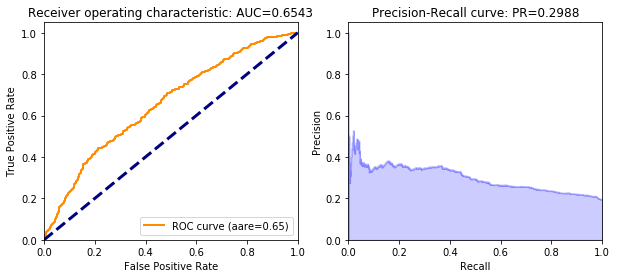

In [35]:
ROC_AUC(glm_v1,test_hex1,'loan_default')

#### GLM on entire dataset (no regularization) <a class="anchor" id="3.2"></a>

In [41]:
train_hex2 = h2o.H2OFrame(train)
test_hex2 = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [42]:
predictors=train.drop(labels=['loan_default'], axis=1).columns.to_list()
target='loan_default'

In [44]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
glm_v2 = H2OGeneralizedLinearEstimator(model_id='glm_v2',family= "binomial",
                                          lambda_ = 0,
                                          compute_p_values = True,seed=1234)
glm_v2.train(predictors,target,training_frame=train_hex2)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [46]:
createGains(glm_v2,test_hex2)

glm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,2400,716,1684,2400,716,1684,0.15,0.09,464.6,1.54,6.0,29.83
1,2400,737,1663,4800,1453,3347,0.31,0.17,929.2,1.56,14.0,30.27
2,2400,706,1694,7200,2159,5041,0.46,0.26,1393.8,1.55,20.0,29.99
3,2400,669,1731,9600,2828,6772,0.61,0.35,1858.4,1.52,26.0,29.46
4,2400,301,2099,12000,3129,8871,0.67,0.46,2323.0,1.35,21.0,26.08
5,2400,302,2098,14400,3431,10969,0.74,0.57,2787.6,1.23,17.0,23.83
6,2400,282,2118,16800,3713,13087,0.80,0.68,3252.2,1.14,12.0,22.10
7,2400,297,2103,19200,4010,15190,0.86,0.78,3716.8,1.08,8.0,20.89
8,2400,325,2075,21600,4335,17265,0.93,0.89,4181.4,1.04,4.0,20.07


glm prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



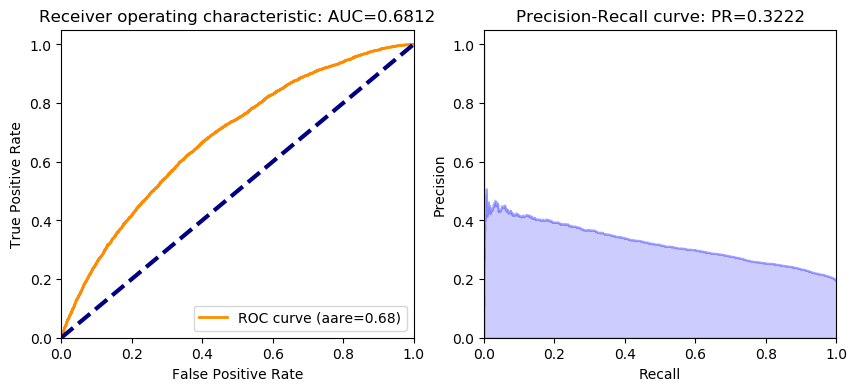

In [47]:
# ROC PR curves
ROC_AUC(glm_v2,test_hex2,'loan_default')

#### GLM on entire dataset (with regularization) <a class="anchor" id="3.3"></a>

In [77]:
train_hex3 = h2o.H2OFrame(train)
test_hex3 = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [49]:
predictors=train.drop(labels=['loan_default'], axis=1).columns.to_list()
target='loan_default'

In [79]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
glm_v3 = H2OGeneralizedLinearEstimator(model_id='glm_v3',family= "binomial",
                                          lambda_search = True)
glm_v3.train(predictors,target,training_frame=train_hex3)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [80]:
createGains(glm_v3,test_hex3)

glm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,2400,716,1684,2400,716,1684,0.15,0.09,464.6,1.54,6.0,29.83
1,2400,741,1659,4800,1457,3343,0.31,0.17,929.2,1.57,14.0,30.35
2,2400,700,1700,7200,2157,5043,0.46,0.26,1393.8,1.55,20.0,29.96
3,2400,665,1735,9600,2822,6778,0.61,0.35,1858.4,1.52,26.0,29.40
4,2400,322,2078,12000,3144,8856,0.68,0.46,2323.0,1.35,22.0,26.20
5,2400,274,2126,14400,3418,10982,0.74,0.57,2787.6,1.23,17.0,23.74
6,2400,296,2104,16800,3714,13086,0.80,0.68,3252.2,1.14,12.0,22.11
7,2400,294,2106,19200,4008,15192,0.86,0.78,3716.8,1.08,8.0,20.88
8,2400,328,2072,21600,4336,17264,0.93,0.89,4181.4,1.04,4.0,20.07


glm prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



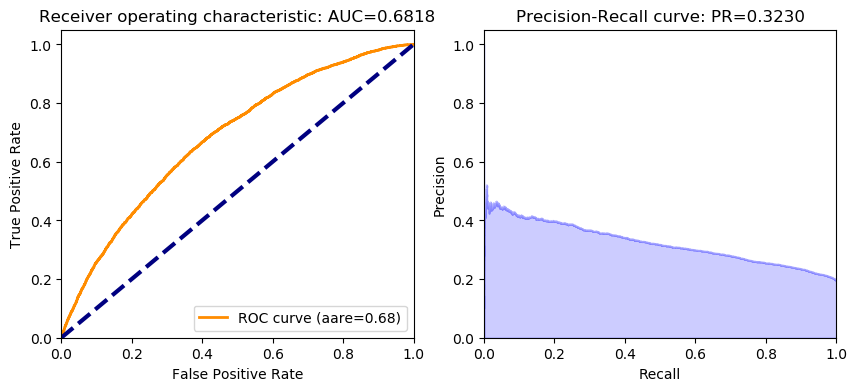

In [81]:
ROC_AUC(glm_v3,test_hex3,'loan_default')

#### GLM on entire dataset (with regularization, random oversampling)  <a class="anchor" id="3.4"></a>

In [82]:
# define oversampling strategy
from imblearn.over_sampling import RandomOverSampler
sampler = RandomOverSampler(sampling_strategy=0.5)
X_over, y_over = sampler.fit_sample(train.drop(labels=['loan_default'], axis=1), train[['loan_default']])

In [83]:
train_random_over=pd.concat([X_over,y_over],axis=1)

In [84]:
train_random_over_hex4=h2o.H2OFrame(train_random_over)
test_hex4 = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [85]:
predictors=train.drop(labels=['loan_default'], axis=1).columns.to_list()
target='loan_default'

In [88]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

glm_v4 = H2OGeneralizedLinearEstimator(model_id = 'glm_v4',family= "binomial",
                                          lambda_search = True)
glm_v4.train(predictors,target,training_frame=train_random_over_hex4)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [100]:
createGains(glm_v4,test_hex4)

glm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,2400,647,1753,2400,647,1753,0.14,0.09,464.6,1.39,5.0,26.96
1,2400,657,1743,4800,1304,3496,0.28,0.18,929.2,1.40,10.0,27.17
2,2400,654,1746,7200,1958,5242,0.42,0.27,1393.8,1.40,15.0,27.19
3,2400,608,1792,9600,2566,7034,0.55,0.36,1858.4,1.38,19.0,26.73
4,2400,577,1823,12000,3143,8857,0.68,0.46,2323.0,1.35,22.0,26.19
5,2400,482,1918,14400,3625,10775,0.78,0.56,2787.6,1.30,22.0,25.17
6,2400,235,2165,16800,3860,12940,0.83,0.67,3252.2,1.19,16.0,22.98
7,2400,249,2151,19200,4109,15091,0.88,0.78,3716.8,1.11,10.0,21.40
8,2400,281,2119,21600,4390,17210,0.94,0.89,4181.4,1.05,5.0,20.32


glm prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



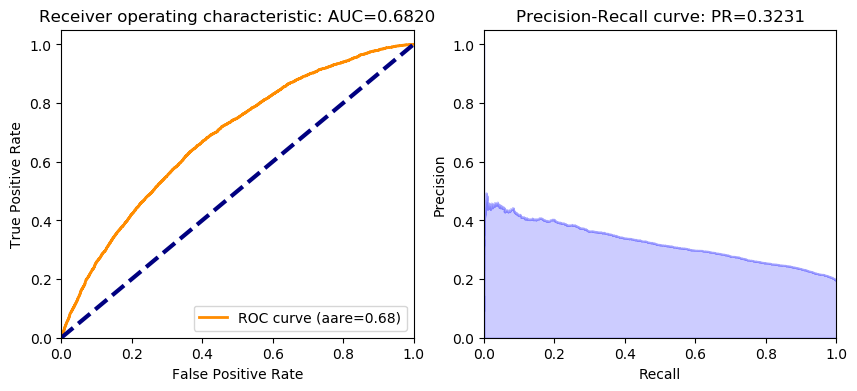

In [103]:
ROC_AUC(glm_v4,test_hex4,'loan_default')

#### GLM on entire dataset (with regularization, random undersampling) <a class="anchor" id="3.5"></a>

In [91]:
# define oversampling strategy
from imblearn.under_sampling import RandomUnderSampler
sampler = RandomUnderSampler(sampling_strategy=0.5)
X_under, y_under = sampler.fit_sample(train.drop(labels=['loan_default'], axis=1), train[['loan_default']])

In [92]:
train_random_under=pd.concat([X_under,y_under],axis=1)

In [93]:
train_random_under_hex5=h2o.H2OFrame(train_random_under)
test_hex5 = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [94]:
predictors=train.drop(labels=['loan_default'], axis=1).columns.to_list()
target='loan_default'

In [104]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
glm_v5 = H2OGeneralizedLinearEstimator(model_id = 'glm_v5',family= "binomial",
                                          lambda_search = True)
glm_v5.train(predictors,target,training_frame=train_random_under_hex5)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [105]:
createGains(glm_v5,test_hex5)

glm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,2400,636,1764,2400,636,1764,0.14,0.09,464.6,1.37,5.0,26.50
1,2400,672,1728,4800,1308,3492,0.28,0.18,929.2,1.41,10.0,27.25
2,2400,673,1727,7200,1981,5219,0.43,0.27,1393.8,1.42,16.0,27.51
3,2400,642,1758,9600,2623,6977,0.56,0.36,1858.4,1.41,20.0,27.32
4,2400,608,1792,12000,3231,8769,0.70,0.45,2323.0,1.39,25.0,26.92
5,2400,389,2011,14400,3620,10780,0.78,0.56,2787.6,1.30,22.0,25.14
6,2400,252,2148,16800,3872,12928,0.83,0.67,3252.2,1.19,16.0,23.05
7,2400,231,2169,19200,4103,15097,0.88,0.78,3716.8,1.10,10.0,21.37
8,2400,279,2121,21600,4382,17218,0.94,0.89,4181.4,1.05,5.0,20.29


glm prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



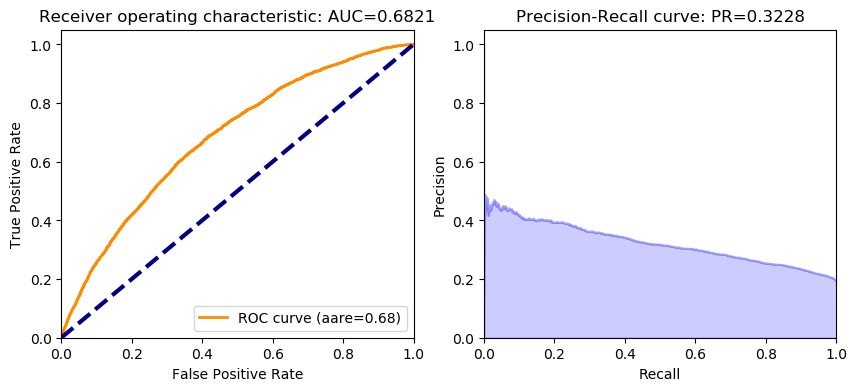

In [106]:
ROC_AUC(glm_v5,test_hex5,'loan_default')

The best model for GLM is GLM with with regularization. The lift score is 1.54, the ROC AUC is 0.6818 and the PR AUC is 0.323
https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/glm.html

### AutoML  <a class="anchor" id="4"></a>

In [107]:
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [108]:
from h2o.automl import H2OAutoML
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=predictors, y=target, training_frame=train_hex)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows) 

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20201121_204440,0.143417,0.378704,0.143417,0.287489,0.265783
StackedEnsemble_BestOfFamily_AutoML_20201121_204440,0.143731,0.379119,0.143731,0.288431,0.266132
GBM_1_AutoML_20201121_204440,0.144481,0.380107,0.144481,0.290212,0.266698
GBM_grid__1_AutoML_20201121_204440_model_1,0.144683,0.380373,0.144683,0.290608,0.266866
GBM_2_AutoML_20201121_204440,0.144792,0.380515,0.144792,0.289995,0.267149
GBM_3_AutoML_20201121_204440,0.145294,0.381175,0.145294,0.289941,0.267792
XGBoost_grid__1_AutoML_20201121_204440_model_4,0.145419,0.381338,0.145419,0.288847,0.268195
GLM_1_AutoML_20201121_204440,0.14552,0.38147,0.14552,0.294299,0.268069
GBM_5_AutoML_20201121_204440,0.145537,0.381493,0.145537,0.288804,0.268256
XGBoost_3_AutoML_20201121_204440,0.145857,0.381913,0.145857,0.289356,0.268737


In [115]:
createGains(aml,test_hex)

stackedensemble prediction progress: |████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,2400,964,1436,2400,964,1436,0.21,0.07,464.6,2.07,14.0,40.17
1,2400,746,1654,4800,1710,3090,0.37,0.16,929.2,1.84,21.0,35.62
2,2400,672,1728,7200,2382,4818,0.51,0.25,1393.8,1.71,26.0,33.08
3,2400,520,1880,9600,2902,6698,0.62,0.35,1858.4,1.56,27.0,30.23
4,2400,471,1929,12000,3373,8627,0.73,0.45,2323.0,1.45,28.0,28.11
5,2400,375,2025,14400,3748,10652,0.81,0.55,2787.6,1.34,26.0,26.03
6,2400,327,2073,16800,4075,12725,0.88,0.66,3252.2,1.25,22.0,24.26
7,2400,281,2119,19200,4356,14844,0.94,0.77,3716.8,1.17,17.0,22.69
8,2400,189,2211,21600,4545,17055,0.98,0.88,4181.4,1.09,10.0,21.04


In [118]:
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
#     print(y_pred[['p1']])
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)
    
    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')
    
    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()

stackedensemble prediction progress: |████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



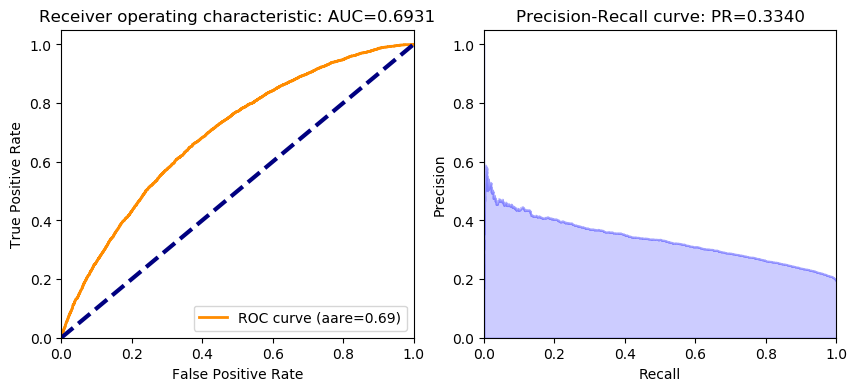

In [119]:
ROC_AUC(aml,test_hex,'loan_default')

The best model from automl gives a lift score of 2.07, the ROC AUC is 0.6931 and the PR AUC is 0.334.